In [1]:
import WesBotTWO as wb
import HandOddsCalcWes as hoc

import texasholdem as th
import texasholdem.evaluator as eval
import numpy as np
import pandas as pd
import random
from tqdm import trange

In [2]:
# smort_decision(our_bot:PokerBot, game:th.TexasHoldEm)
# actually make a goddamn decision using my scuffed bot thingy, and record
# all the necessary information for Shro' to use in his thing
# INPUTS:
#   our_bot: a PokerBot object, supposed to be intelligent or something
#   game:    a TexasHoldEm game object that we're playing
# OUTPUT:
#   a list containing:
#     [hand_phase:str,
#      my_hand:list of th.Card,
#      board:list of th.Card,
#      EV:float,
#      my_chips_betting:int,
#      their_chips_betting:int,
#      my_decision:Decision]
# SIDE EFFECT:
#   makes the decision in the TexasHoldEm game object passed in
def smort_decision(our_bot:wb.PokerBot, game:th.TexasHoldEm):
  # get information regarding our hand, the game board, our win prob,
  # their chips bet, and our EV
  win_prob =  hoc.estimate_win_prob(game, game.current_player, 2, 1000)
  loss_prob = 1 - win_prob
  my_chips_betting = game.player_bet_amount(0)
  their_chips_betting = game.player_bet_amount(1)
  EV = win_prob*their_chips_betting - loss_prob*(my_chips_betting + \
                                                 game.chips_to_call(0))
  # get features for Shro'
  my_decision = our_bot.make_decision(EV, game)
  my_hand = game.get_hand(game.current_player)
  board = []
  for card in game.board:
    board.append(card)
  # record hand phase
  hand_phase = game.hand_phase.name
  # actually make the decision
  if (my_decision.type == "RAISE"):
    if (game.validate_move(action = th.ActionType.RAISE,\
                           value = my_decision.size)):
      game.take_action(th.ActionType.RAISE, my_decision.size)
    else:
      game.take_action(th.ActionType.ALL_IN)
  elif (my_decision.type == "CALL/CHECK"):
    if (game.validate_move(action = th.ActionType.CALL)):
      game.take_action(th.ActionType.CALL)
    else:
      game.take_action(th.ActionType.CHECK)
  elif (my_decision.type == "FOLD"):
    game.take_action(th.ActionType.FOLD)
  else:
    game.take_action(th.ActionType.ALL_IN)
  output = [hand_phase, my_hand, board, EV, my_chips_betting, their_chips_betting, my_decision]
  return output

# baby_decision(game:th.TexasHoldEm)
# make a random decision for the opponent, just to get someone to play against
# INPUTS:
#   game: a th.TexasHoldEm object that we're playing
# SIDE EFFECT:
#   makes the random decision in the game object passed in
def baby_decision(game:th.TexasHoldEm):
  # make random decision
  if (np.random.rand() > 0.5):
    # baby gonna raise
    min_raise = int(game.get_available_moves().raise_range.start)
    max_raise = int(np.min([game.players[0].chips,
                            game.get_available_moves().raise_range.stop]))
    # make sure we only raise by some reasonable amount
    max_raise = int((3*min_raise + max_raise) // 4)
    if (max_raise - min_raise > 20):
      max_raise = min_raise + 20
    decision = \
      wb.Decision("RAISE", int(np.random.uniform(min_raise, max_raise)))
  else:
    # baby gonna call/check
    decision = wb.Decision("CALL/CHECK")
  # ensure validity of decision and actually make decision
  if (decision.type == "RAISE" and
      game.validate_move(action = th.ActionType.RAISE, value = decision.size)):
    game.take_action(th.ActionType.RAISE, decision.size)
    return -1
  elif (game.validate_move(action = th.ActionType.CALL)):
    game.take_action(th.ActionType.CALL)
    return -1
  elif (game.validate_move(action = th.ActionType.CHECK)):
    game.take_action(th.ActionType.CHECK)
    return -1
  game.take_action(th.ActionType.FOLD)
  return 0
  
      

In [3]:
epochs = 5000
our_bot = wb.PokerBot(maturity=epochs//4)

rounds_list = []

for i in trange(epochs):
  game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
  game.start_hand()
  current_round = []
  while (game.is_hand_running()):
    # branch on whose turn
    if (game.current_player == 0):
      our_decision = smort_decision(our_bot, game)
      current_round.append(our_decision)
      if (our_decision[6].type == "FOLD"):
        who_won = 1
      else:
        who_won = -1
    else:
      who_won = baby_decision(game)
    if (who_won == -1 and len(game.board) == 5):
      jerry_hand_rank = eval.evaluate(game.get_hand(0), game.board)
      tom_hand_rank = eval.evaluate(game.get_hand(1), game.board)
      who_won = int(jerry_hand_rank >= tom_hand_rank)
  # now round is done, close round and go again
  won_or_lost_chips = game._get_last_pot().amount*((-1)**who_won)
  our_bot.log_round(won_or_lost_chips)
  rounds_list.append([current_round, won_or_lost_chips])


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [2:51:29<00:00,  2.06s/it]  


In [4]:
outcomes = np.zeros(len(rounds_list))

for i in range(len(rounds_list)):
  outcomes[i] = rounds_list[i][1]

print("Avg. outcomes:", np.mean(outcomes))
print("Avg. win rate:", np.mean(outcomes > 0))

Avg. outcomes: 17.6518
Avg. win rate: 0.3066


In [5]:
class Node:
    def __init__(self, decision, children=None):
        self.decision = decision
        self.children = children if children else []

    def add_child(self, child_node):
        self.children.append(child_node)

class DecisionTree:
    def __init__(self, root, outcome):
        self.root = root
        self.outcome = outcome

# Create decision trees from rounds_list
decision_trees = []
for round_entry in rounds_list:
    decisions = round_entry[0]  # The list of decisions
    outcome = round_entry[1]    # The outcome (tail of the entry)

    # Build the tree structure
    root = Node(decisions[0])  # First decision as the root
    current_node = root
    for decision in decisions[1:]:
        new_node = Node(decision)
        current_node.add_child(new_node)
        current_node = new_node

    decision_trees.append(DecisionTree(root, outcome))



# Print the structure of the first tree
def print_tree(node, depth=0):
    print("  " * depth + f"Decision: {node.decision}")
    for child in node.children:
        print_tree(child, depth + 1)


print_tree(decision_trees[0].root)
print("Outcome:", decision_trees[0].outcome)

Decision: ['PREFLOP', [Card("2h"), Card("Td")], [], np.float64(-0.4600000000000004), 2, 5, <WesBotTWO.Decision object at 0x00000253C55D08C0>]
  Decision: ['PREFLOP', [Card("2h"), Card("Td")], [], np.float64(-2.631999999999998), 5, 28, <WesBotTWO.Decision object at 0x00000253C4138FB0>]
    Decision: ['FLOP', [Card("2h"), Card("Td")], [Card("9s"), Card("Ks"), Card("6c")], np.float64(-2.3640000000000003), 0, 6, <WesBotTWO.Decision object at 0x00000253C4556060>]
      Decision: ['TURN', [Card("2h"), Card("Td")], [Card("9s"), Card("Ks"), Card("6c"), Card("Ah")], np.float64(0.0), 0, 0, <WesBotTWO.Decision object at 0x00000253C55D0A40>]
        Decision: ['RIVER', [Card("2h"), Card("Td")], [Card("9s"), Card("Ks"), Card("6c"), Card("Ah"), Card("3c")], np.float64(0.0), 0, 0, <WesBotTWO.Decision object at 0x00000253C55D09E0>]
Outcome: 122


In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces, Env  # Use gymnasium instead of gym
import numpy as np

# Define a custom environment for decision trees
class DecisionTreeEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, decision_trees):
        self.decision_trees = decision_trees
        self.current_tree_idx = 0
        self.current_node = None
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.current_tree_idx = np.random.randint(len(self.decision_trees))
        self.current_node = self.decision_trees[self.current_tree_idx].root
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = "RAISE"
        elif action == 1:
            decision = "CALL/CHECK"
        else:
            decision = "FOLD"

        info = {}  # Additional information can be added here
        reward = self.decision_trees[self.current_tree_idx].outcome
        done = True  # End after one decision for simplicity
        return self._get_observation(), reward, done, {"decision": decision}, info

    def _get_observation(self):
        # Convert the current node's decision into a numerical observation
        hand_phase = self.current_node.decision[0]
        my_hand = self.current_node.decision[1]
        board = self.current_node.decision[2]
        EV = self.current_node.decision[3]
        my_chips_betting = self.current_node.decision[4]
        their_chips_betting = self.current_node.decision[5]
        decision_type = self.current_node.decision[6].type

        # Map hand_phase and decision_type to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        decision_type_map = {"RAISE": 0, "CALL/CHECK": 1, "FOLD": 2}

        hand_phase_num = hand_phase_map.get(hand_phase, -1)
        decision_type_num = decision_type_map.get(decision_type, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            decision_type_num
        ], dtype=np.float32)

# Wrap the environment
env = DummyVecEnv([lambda: DecisionTreeEnv(decision_trees)])

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Save the model
model.save("ppo_decision_tree_model")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1635 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011517271 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -3.45e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.33e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00633    |
|    value_loss           | 9.74e+04    |
-----------------------------------------
-----------------

Simulating games: 100%|██████████| 1000/1000 [22:44<00:00,  1.36s/it]

PPO Bot Total Earnings: 11726
SMORT Bot Total Earnings: -11726


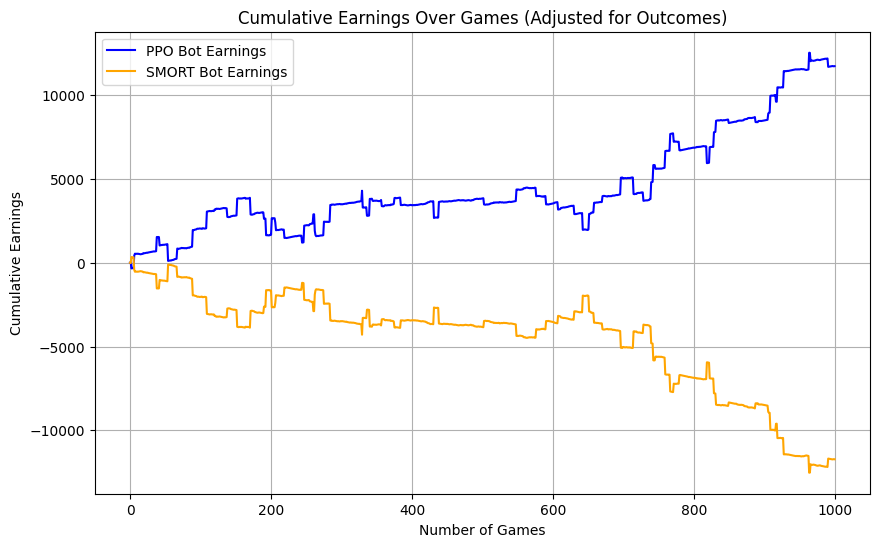

In [19]:
from matplotlib import pyplot as plt
from tqdm import tqdm

# Reset metrics
ppo_bot_earnings = 0
ppo_cumulative_earnings = []

smort_bot_earnings = 0
smort_cumulative_earnings = []
smort_bot_decisions = []

total_games = 1000
for idx, _ in enumerate(tqdm(range(total_games), desc="Simulating games")):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            smort_bot_decisions.append(smort_decision_result)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # PPO bot wins
            else:
                who_won = -1
        else:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[0].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                # Ensure CHECK is only attempted when valid
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        jerry_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        tom_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = int(jerry_hand_rank >= tom_hand_rank)

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount
    if who_won == 0:
        ppo_bot_earnings += won_or_lost_chips
        smort_bot_earnings += -won_or_lost_chips
    else:
        smort_bot_earnings += won_or_lost_chips
        ppo_bot_earnings += -won_or_lost_chips


    # Update cumulative earnings
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    smort_cumulative_earnings.append(smort_bot_earnings)

# Print metrics
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("SMORT Bot Total Earnings:", smort_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games (Adjusted for Outcomes)")
plt.legend()
plt.grid()
plt.show()


In [20]:
from stable_baselines3 import A2C

# Define a custom environment for the 4th bot
class FourthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, opponent_bot, decision_trees):
        self.opponent_bot = opponent_bot
        self.decision_trees = decision_trees
        self.current_tree_idx = 0
        self.current_node = None
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.current_tree_idx = np.random.randint(len(self.decision_trees))
        self.current_node = self.decision_trees[self.current_tree_idx].root
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = "RAISE"
        elif action == 1:
            decision = "CALL/CHECK"
        else:
            decision = "FOLD"

        # Calculate reward based on the outcome
        info = {}  # Additional information can be added here
        reward = self.decision_trees[self.current_tree_idx].outcome
        done = True  # End after one decision for simplicity
        return self._get_observation(), reward, done, {"decision": decision}, info

    def _get_observation(self):
        # Convert the current node's decision into a numerical observation
        hand_phase = self.current_node.decision[0]
        my_hand = self.current_node.decision[1]
        board = self.current_node.decision[2]
        EV = self.current_node.decision[3]
        my_chips_betting = self.current_node.decision[4]
        their_chips_betting = self.current_node.decision[5]
        decision_type = self.current_node.decision[6].type

        # Map hand_phase and decision_type to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        decision_type_map = {"RAISE": 0, "CALL/CHECK": 1, "FOLD": 2}

        hand_phase_num = hand_phase_map.get(hand_phase, -1)
        decision_type_num = decision_type_map.get(decision_type, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            decision_type_num
        ], dtype=np.float32)

# Train the 4th bot against SMORT bot
fourth_bot_env = DummyVecEnv([lambda: FourthBotEnv(our_bot, decision_trees)])
fourth_bot_model = A2C("MlpPolicy", fourth_bot_env, verbose=1)

# Train the model
fourth_bot_model.learn(total_timesteps=100000)

# Save the model
fourth_bot_model.save("a2c_fourth_bot_model")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 518      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.08    |
|    explained_variance | 0.00195  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 198      |
|    value_loss         | 1.15e+05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 559      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.995   |
|    explained_variance | -0.00163 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -86.2    |
|    value_loss      

Simulating games:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games: 100%|██████████| 1000/1000 [27:58<00:00,  1.68s/it]

SMORT Bot Total Earnings: -490438
Fourth Bot Total Earnings: 668340


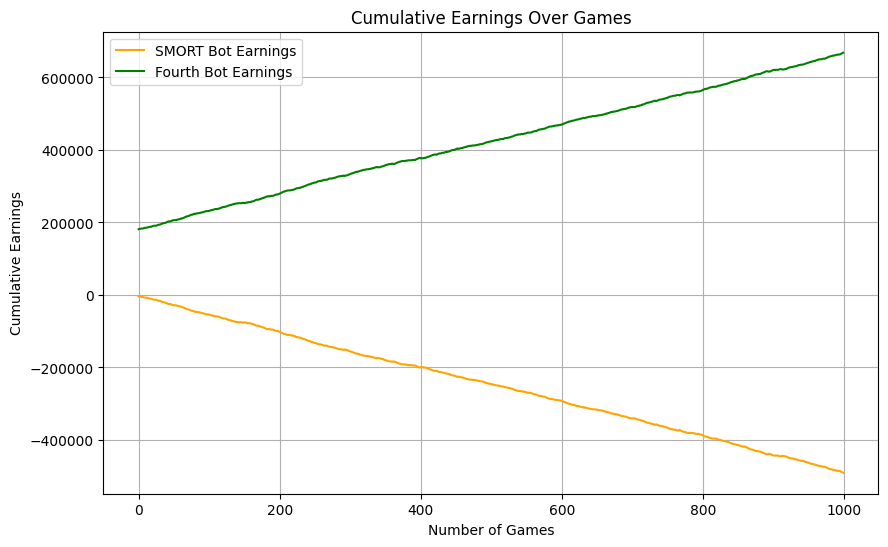

In [22]:
# Import
smort_cumulative_earnings = []
fourth_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # Fourth bot wins
            else:
                who_won = -1
        else:  # Fourth bot's turn
            obs = fourth_bot_env.reset()
            action, _ = fourth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        fourth_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = np.argmax([smort_hand_rank, fourth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
        fourth_bot_earnings += -won_or_lost_chips
    else:
        fourth_bot_earnings += won_or_lost_chips
        smort_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    fourth_cumulative_earnings.append(fourth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("Fourth Bot Total Earnings:", fourth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), fourth_cumulative_earnings, label="Fourth Bot Earnings", color="green")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()


In [23]:
from stable_baselines3 import A2C

# Define a custom environment for the 5th bot
class FifthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, game):
        self.game = game
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        # Reinitialize the game if it is not already initialized or if no hand is running
        if not hasattr(self, 'game') or not self.game.is_hand_running():
            self.game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)  # Reinitialize the game
            self.game.start_hand()  # Start a new hand in the game
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = (th.ActionType.RAISE, self._get_raise_amount())
        elif action == 1:
            decision = (th.ActionType.CALL, None)
        else:
            decision = (th.ActionType.FOLD, None)

        # Execute the decision
        if decision[0] == th.ActionType.RAISE and self.game.validate_move(action=decision[0], value=decision[1]):
            self.game.take_action(decision[0], decision[1])
        elif decision[0] == th.ActionType.CALL and self.game.validate_move(action=decision[0]):
            self.game.take_action(decision[0])
        elif decision[0] == th.ActionType.FOLD:
            self.game.take_action(decision[0])
        else:
            if self.game.validate_move(action=th.ActionType.CHECK):
                self.game.take_action(th.ActionType.CHECK)
            else:
                self.game.take_action(th.ActionType.FOLD)

        # Calculate reward and determine if the game is done
        info = {}  # Additional information can be added here
        reward = self.game._get_last_pot().amount * ((-1) ** self.game.current_player)
        done = not self.game.is_hand_running()
        return self._get_observation(), reward, done, {}, info

    def _get_observation(self):
        # Extract relevant game state information
        hand_phase = self.game.hand_phase.name
        my_hand = self.game.get_hand(self.game.current_player)
        board = self.game.board
        EV = hoc.estimate_win_prob(self.game, self.game.current_player, 2, 1000)
        my_chips_betting = self.game.player_bet_amount(self.game.current_player)
        their_chips_betting = self.game.player_bet_amount(1 - self.game.current_player)

        # Map hand_phase to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        hand_phase_num = hand_phase_map.get(hand_phase, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            0  # Placeholder for decision type (not needed here)
        ], dtype=np.float32)

    def _get_raise_amount(self):
        min_raise = int(self.game.get_available_moves().raise_range.start)
        max_raise = int(np.min([self.game.players[self.game.current_player].chips,
                                self.game.get_available_moves().raise_range.stop]))
        return int(min_raise + (max_raise - min_raise) // 2)  # Example: mid-point raise

# Train the 5th bot against SMORT bot
fifth_bot_env = DummyVecEnv([lambda: FifthBotEnv(game)])
fifth_bot_model = A2C("MlpPolicy", fifth_bot_env, verbose=1)

# Train the model
fifth_bot_model.learn(total_timesteps=10000)

# Save the model
fifth_bot_model.save("a2c_fifth_bot_model")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 9        |
|    iterations         | 100      |
|    time_elapsed       | 53       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.07    |
|    explained_variance | 0.000948 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -591     |
|    value_loss         | 3.32e+05 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 9         |
|    iterations         | 200       |
|    time_elapsed       | 106       |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.05     |
|    explained_variance | -4.29e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | 4.48      |
|    valu

Using cpu device


Simulating games: 100%|██████████| 1000/1000 [21:22<00:00,  1.28s/it]

SMORT Bot Total Earnings: 238257.0
Fifth Bot Total Earnings: -238257.0


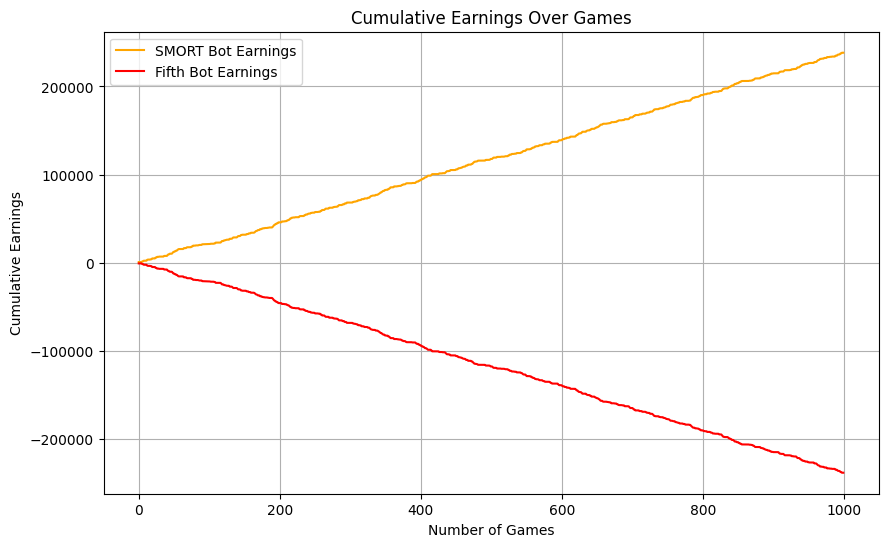

In [24]:
# Reset metrics
fifth_bot_earnings = 0
smort_bot_earnings = 0

# Initialize fifth_bot_vs_smort_env
fifth_bot_vs_smort_env = fifth_bot_env  # Use the underlying Gym environment directly

# Initialize fifth_bot_vs_smort_model
fifth_bot_vs_smort_model = A2C("MlpPolicy", fifth_bot_vs_smort_env, verbose=1)

fifth_cumulative_earnings = []
smort_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # Fifth bot wins
            else:
                who_won = -1
        else:  # Fifth bot's turn
            obs = fifth_bot_vs_smort_env.reset()
            action, _ = fifth_bot_vs_smort_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        fifth_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = np.argmax([smort_hand_rank, fifth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
        fifth_bot_earnings += -won_or_lost_chips
    else:
        fifth_bot_earnings += won_or_lost_chips
        smort_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    fifth_cumulative_earnings.append(fifth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("Fifth Bot Total Earnings:", fifth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), fifth_cumulative_earnings, label="Fifth Bot Earnings", color="red")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()


In [25]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces, Env
import numpy as np

# Define a custom environment for the 6th bot
class SixthBotEnv(Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, smort_bot, game):
        self.smort_bot = smort_bot
        self.game = game
        self.action_space = spaces.Discrete(3)  # Example: 3 actions (RAISE, CALL, FOLD)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure compatibility with gymnasium
        self.game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
        self.game.start_hand()
        return self._get_observation(), {}

    def step(self, action):
        # Map action to decision
        if action == 0:
            decision = (th.ActionType.RAISE, self._get_raise_amount())
        elif action == 1:
            decision = (th.ActionType.CALL, None)
        else:
            decision = (th.ActionType.FOLD, None)

        # Execute the decision
        if decision[0] == th.ActionType.RAISE and self.game.validate_move(action=decision[0], value=decision[1]):
            self.game.take_action(decision[0], decision[1])
        elif decision[0] == th.ActionType.CALL and self.game.validate_move(action=decision[0]):
            self.game.take_action(decision[0])
        elif decision[0] == th.ActionType.FOLD:
            self.game.take_action(decision[0])
        else:
            if self.game.validate_move(action=th.ActionType.CHECK):
                self.game.take_action(th.ActionType.CHECK)
            else:
                self.game.take_action(th.ActionType.FOLD)

        # SMORT bot's turn
        if self.game.is_hand_running():
            smort_decision(self.smort_bot, self.game)

        # Calculate reward and determine if the game is done
        reward = self.game._get_last_pot().amount * ((-1) ** self.game.current_player)
        done = not self.game.is_hand_running()
        return self._get_observation(), reward, done, {}, {}

    def _get_observation(self):
        # Extract relevant game state information
        hand_phase = self.game.hand_phase.name
        my_hand = self.game.get_hand(self.game.current_player)
        board = self.game.board
        EV = hoc.estimate_win_prob(self.game, self.game.current_player, 2, 1000)
        my_chips_betting = self.game.player_bet_amount(self.game.current_player)
        their_chips_betting = self.game.player_bet_amount(1 - self.game.current_player)

        # Map hand_phase to numerical values
        hand_phase_map = {"PREFLOP": 0, "FLOP": 1, "TURN": 2, "RIVER": 3}
        hand_phase_num = hand_phase_map.get(hand_phase, -1)

        # Create the observation array
        return np.array([
            hand_phase_num,
            len(my_hand),  # Number of cards in hand
            len(board),    # Number of cards on the board
            EV,
            my_chips_betting,
            their_chips_betting,
            0  # Placeholder for decision type (not needed here)
        ], dtype=np.float32)

    def _get_raise_amount(self):
        min_raise = int(self.game.get_available_moves().raise_range.start)
        max_raise = int(np.min([self.game.players[self.game.current_player].chips,
                                self.game.get_available_moves().raise_range.stop]))
        return int(min_raise + (max_raise - min_raise) // 2)  # Example: mid-point raise

# Train the 6th bot against SMORT bot
sixth_bot_env = DummyVecEnv([lambda: SixthBotEnv(our_bot, game)])
sixth_bot_model = PPO("MlpPolicy", sixth_bot_env, verbose=1)

# Train the model
sixth_bot_model.learn(total_timesteps=5000)

# Save the model
sixth_bot_model.save("ppo_sixth_bot_model")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1    |
|    iterations      | 1    |
|    time_elapsed    | 1242 |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1          |
|    iterations           | 2          |
|    time_elapsed         | 2580       |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02973079 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.08      |
|    explained_variance   | -2.4e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 7.4e+04    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0507    |
|    value_loss           | 1.56e+05   |
----------------------------------------
-----------------------------------

Simulating games: 100%|██████████| 1000/1000 [21:30<00:00,  1.29s/it]

SMORT Bot Total Earnings: -227722
Sixth Bot Total Earnings: 227722


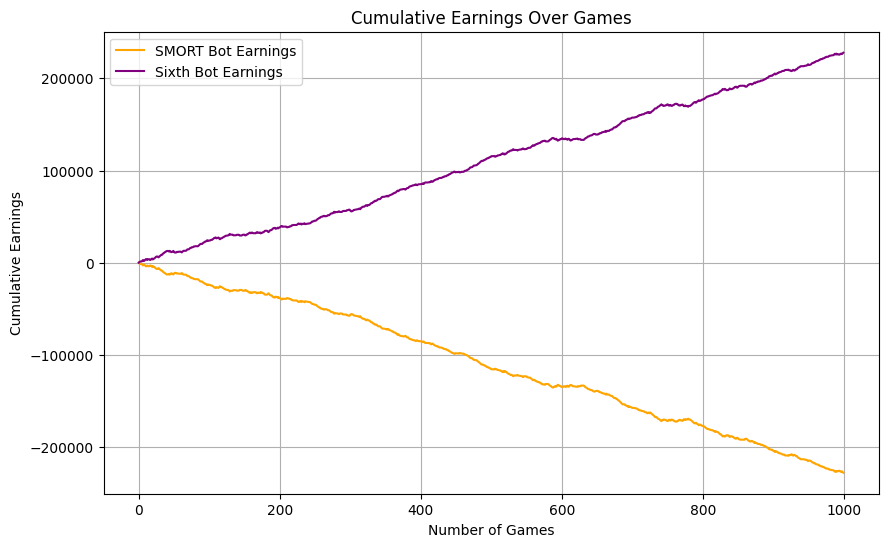

In [27]:
# Reset metrics
smort_bot_earnings = 0
sixth_bot_earnings = 0

smort_cumulative_earnings = []
sixth_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game with only two players
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # Sixth bot wins
            else:
                who_won = -1
        else:  # Sixth bot's turn
            obs = sixth_bot_env.reset()
            action, _ = sixth_bot_model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[1].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        sixth_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = np.argmax([smort_hand_rank, sixth_hand_rank])

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
        sixth_bot_earnings += -won_or_lost_chips
    else:
        sixth_bot_earnings += won_or_lost_chips
        smort_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    sixth_cumulative_earnings.append(sixth_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("Sixth Bot Total Earnings:", sixth_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), sixth_cumulative_earnings, label="Sixth Bot Earnings", color="purple")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()


In [32]:
from tqdm import tqdm

lower_bound = our_bot.bound_bot
upper_bound = our_bot.bound_top

class DynamicBoundBot:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def update_bounds(self, outcome):
        # Dynamically adjust bounds based on the outcome
        adjustment_factor = 0.1 / (1 + abs(outcome))  # Decrease adjustment over time
        if outcome > 0:  # Winning
            self.upper_bound += adjustment_factor * abs(outcome)
        else:  # Losing
            self.lower_bound -= adjustment_factor * abs(outcome)

    def make_decision(self, EV):
        # Make a decision based on EV and current bounds
        if EV > self.upper_bound:
            return wb.Decision("RAISE", random.randint(min_raise, max_raise))
        elif EV > self.lower_bound:
            return wb.Decision("CALL/CHECK")
        else:
            return wb.Decision("FOLD")

# Initialize the dynamic bound bot
dynamic_bot = DynamicBoundBot(lower_bound, upper_bound)

# Example of using the bot in a game loop with a loading bar
for _ in tqdm(range(100), desc="Simulating games"):
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # Dynamic bot wins
            else:
                who_won = -1
        else:  # Dynamic bot's turn
            EV = hoc.estimate_win_prob(game, game.current_player, 2, 1000)
            decision = dynamic_bot.make_decision(EV)

            if decision.type == "RAISE" and game.validate_move(action=th.ActionType.RAISE, value=decision.size):
                game.take_action(th.ActionType.RAISE, decision.size)
            elif decision.type == "CALL/CHECK" and game.validate_move(action=th.ActionType.CALL):
                game.take_action(th.ActionType.CALL)
            elif decision.type == "FOLD":
                game.take_action(th.ActionType.FOLD)
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        dynamic_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = int(smort_hand_rank >= dynamic_hand_rank)

    # Update bounds based on the outcome
    won_or_lost_chips = game._get_last_pot().amount * ((-1) ** who_won)
    dynamic_bot.update_bounds(won_or_lost_chips)

Simulating games: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


Simulating games: 100%|██████████| 1000/1000 [42:33<00:00,  2.55s/it]

SMORT Bot Total Earnings: -1232
Dynamic Bot Total Earnings: 1232


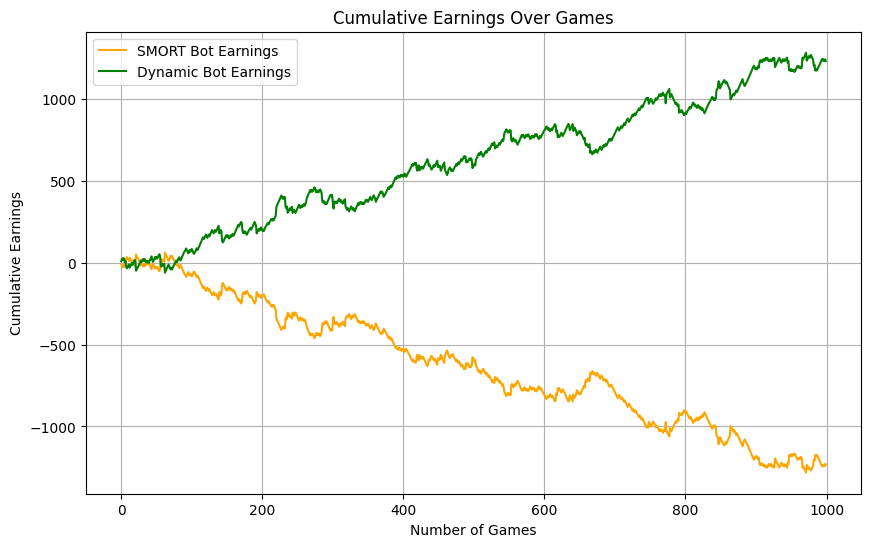

In [38]:
# Reset metrics
dynamic_bot_earnings = 0
smort_bot_earnings = 0

dynamic_cumulative_earnings = []
smort_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # SMORT bot's turn
            smort_decision_result = smort_decision(our_bot, game)
            if smort_decision_result[6].type == "FOLD":
                who_won = 1  # Dynamic bot wins
            else:
                who_won = -1
        else:  # Dynamic bot's turn
            EV = hoc.estimate_win_prob(game, game.current_player, 2, 1000)
            decision = dynamic_bot.make_decision(EV)

            if decision.type == "RAISE" and game.validate_move(action=th.ActionType.RAISE, value=decision.size):
                game.take_action(th.ActionType.RAISE, decision.size)
            elif decision.type == "CALL/CHECK" and game.validate_move(action=th.ActionType.CALL):
                game.take_action(th.ActionType.CALL)
            elif decision.type == "FOLD":
                game.take_action(th.ActionType.FOLD)
                who_won = 0  # SMORT bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        smort_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        dynamic_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = int(smort_hand_rank >= dynamic_hand_rank)

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount
    if who_won == 0:
        smort_bot_earnings += won_or_lost_chips
        dynamic_bot_earnings += -won_or_lost_chips
    else:
        dynamic_bot_earnings += won_or_lost_chips
        smort_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    smort_cumulative_earnings.append(smort_bot_earnings)
    dynamic_cumulative_earnings.append(dynamic_bot_earnings)

# Print metrics
print("SMORT Bot Total Earnings:", smort_bot_earnings)
print("Dynamic Bot Total Earnings:", dynamic_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.plot(range(total_games), dynamic_cumulative_earnings, label="Dynamic Bot Earnings", color="green")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()

Simulating games: 100%|██████████| 100/100 [23:14<00:00, 13.95s/it] 

PPO Bot Total Earnings: 10610
Fourth Bot Total Earnings: 694
Fifth Bot Total Earnings: -1487
Sixth Bot Total Earnings: -872
Dynamic Bot Total Earnings: -8817


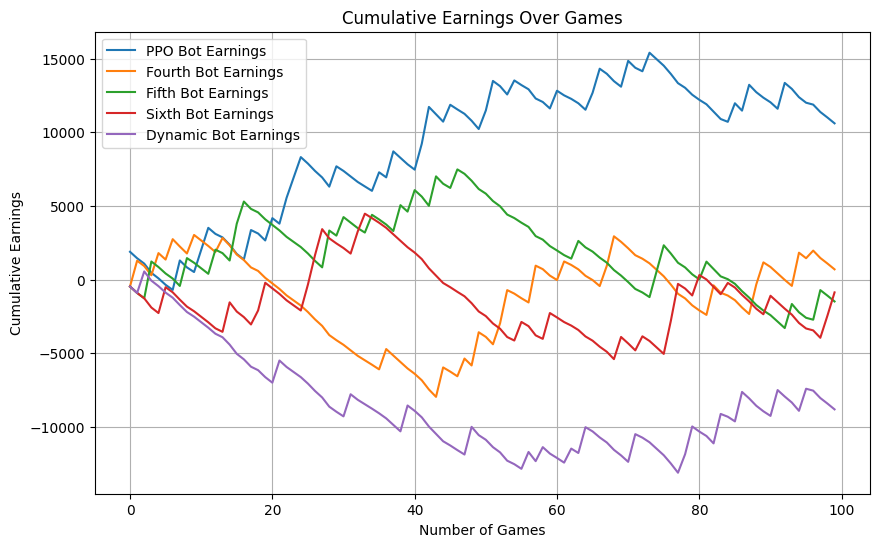

In [44]:
# Define the list of bots
bots = ["PPO", "Fourth", "Fifth", "Sixth", "Dynamic"]

# Reset metrics
bot_earnings = {bot: 0 for bot in bots}
cumulative_earnings = {bot: [] for bot in bots}

# Simulate games
for _ in tqdm(range(100), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=len(bots))
    game.start_hand()

    # Map bot names to their respective models or decision logic
    bot_mapping = {
        "PPO": model,
        "Fourth": fourth_bot_model,
        "Fifth": fifth_bot_model,
        "Sixth": sixth_bot_model,
        "Dynamic": dynamic_bot
    }

    while game.is_hand_running():
        current_bot = bots[game.current_player]
        if current_bot == "Dynamic":
            EV = hoc.estimate_win_prob(game, game.current_player, 2, 1000)
            decision = dynamic_bot.make_decision(EV)
            if decision.type == "RAISE" and game.validate_move(action=th.ActionType.RAISE, value=decision.size):
                game.take_action(th.ActionType.RAISE, decision.size)
            elif decision.type == "CALL/CHECK" and game.validate_move(action=th.ActionType.CALL):
                game.take_action(th.ActionType.CALL)
            elif decision.type == "FOLD":
                game.take_action(th.ActionType.FOLD)
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        else:
            obs = env.reset()
            action, _ = bot_mapping[current_bot].predict(obs)
            if action == 0:
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[game.current_player].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) // 2)
                if game.validate_move(action=th.ActionType.RAISE, value=raise_amount):
                    game.take_action(th.ActionType.RAISE, raise_amount)
            elif action == 1 and game.validate_move(action=th.ActionType.CALL):
                game.take_action(th.ActionType.CALL)
            elif action == 2:
                game.take_action(th.ActionType.FOLD)
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)

    # Determine the winner and update metrics
    pot_amount = game._get_last_pot().amount
    # Determine the winner based on hand ranks or chips
    hand_ranks = [eval.evaluate(game.get_hand(player_id), game.board) for player_id in range(len(bots))]
    winner_id = hand_ranks.index(max(hand_ranks))  # The player with the highest hand rank wins

    for player_id, bot_name in enumerate(bots):
        if player_id == winner_id:
            bot_earnings[bot_name] += pot_amount
        else:
            bot_earnings[bot_name] -= pot_amount // (len(bots) - 1)  # Distribute losses equally among other bots

    # Update cumulative earnings
    for bot_name in bot_earnings:
        cumulative_earnings[bot_name].append(bot_earnings[bot_name])

# Print metrics
for bot_name, earnings in bot_earnings.items():
    print(f"{bot_name} Bot Total Earnings: {earnings}")

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
for bot_name, earnings in cumulative_earnings.items():
    plt.plot(range(100), earnings, label=f"{bot_name} Bot Earnings")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()

Simulating games: 100%|██████████| 1000/1000 [00:01<00:00, 785.84it/s]

PPO Bot Total Earnings: -70093
Baby Bot Total Earnings: 70093


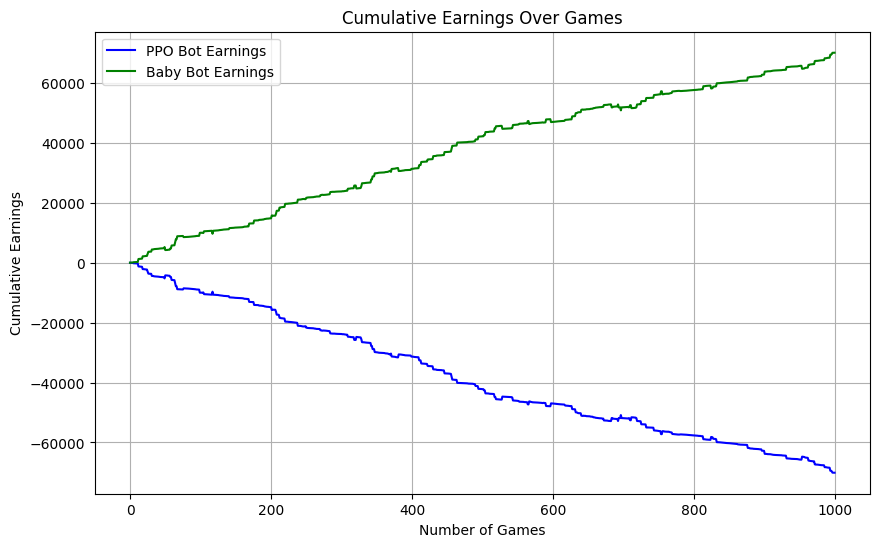

In [46]:
# Reset metrics
ppo_bot_earnings = 0
baby_bot_earnings = 0

ppo_cumulative_earnings = []
baby_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=2)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[0].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
                who_won = 1  # Baby bot wins
            else:
                if game.validate_move(action=th.ActionType.CHECK):
                    game.take_action(th.ActionType.CHECK)
                else:
                    game.take_action(th.ActionType.FOLD)
        else:  # Baby bot's turn
            who_won = baby_decision(game)

    # Determine the winner if the hand reaches showdown
    if who_won == -1 and len(game.board) == 5:
        ppo_hand_rank = eval.evaluate(game.get_hand(0), game.board)
        baby_hand_rank = eval.evaluate(game.get_hand(1), game.board)
        who_won = int(ppo_hand_rank >= baby_hand_rank)

    # Update metrics
    won_or_lost_chips = game._get_last_pot().amount
    if who_won == 0:
        ppo_bot_earnings += won_or_lost_chips
        baby_bot_earnings += -won_or_lost_chips
    else:
        baby_bot_earnings += won_or_lost_chips
        ppo_bot_earnings += -won_or_lost_chips

    # Update cumulative earnings
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    baby_cumulative_earnings.append(baby_bot_earnings)

# Print metrics
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("Baby Bot Total Earnings:", baby_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), baby_cumulative_earnings, label="Baby Bot Earnings", color="green")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()

Simulating games: 100%|██████████| 1000/1000 [15:24<00:00,  1.08it/s]

PPO Bot Total Earnings: -31107
Baby Bot Total Earnings: 62307
SMORT Bot Total Earnings: -30785


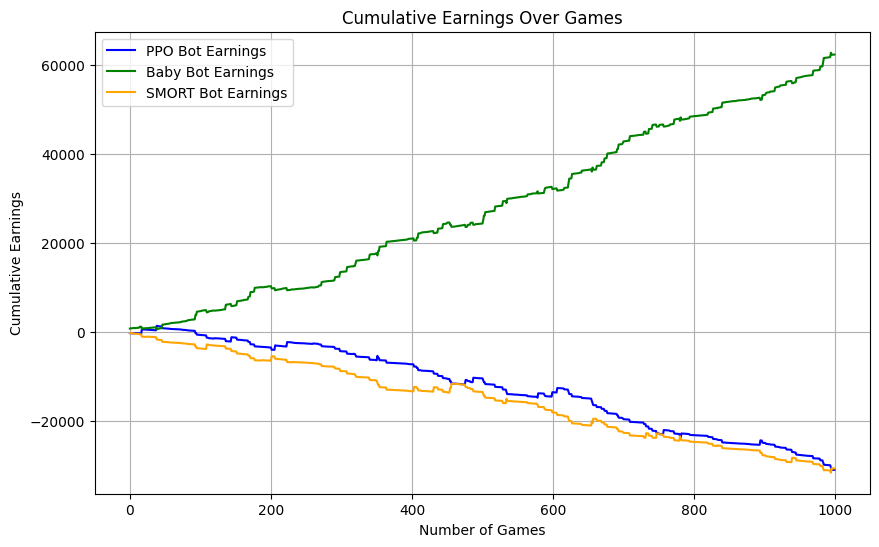

In [47]:
# Reset metrics
ppo_bot_earnings = 0
baby_bot_earnings = 0
smort_bot_earnings = 0

ppo_cumulative_earnings = []
baby_cumulative_earnings = []
smort_cumulative_earnings = []

total_games = 1000

for _ in tqdm(range(total_games), desc="Simulating games"):
    # Initialize a new game with three players
    game = th.TexasHoldEm(buyin=500, big_blind=5, small_blind=2, max_players=3)
    game.start_hand()

    while game.is_hand_running():
        if game.current_player == 0:  # PPO bot's turn
            obs = env.reset()
            action, _ = model.predict(obs)
            decision = None
            if action == 0:
                EV = obs[0][3]  # Extract EV from observation
                min_raise = int(game.get_available_moves().raise_range.start)
                max_raise = int(np.min([game.players[0].chips, game.get_available_moves().raise_range.stop]))
                raise_amount = int(min_raise + (max_raise - min_raise) * max(0, min(1, EV)))
                decision = (th.ActionType.RAISE, raise_amount)
            elif action == 1:
                decision = (th.ActionType.CALL, None)
            else:
                decision = (th.ActionType.FOLD, None)

            if decision[0] == th.ActionType.RAISE and game.validate_move(action=decision[0], value=decision[1]):
                game.take_action(decision[0], decision[1])
            elif decision[0] == th.ActionType.CALL and game.validate_move(action=decision[0]):
                game.take_action(decision[0])
            elif decision[0] == th.ActionType.FOLD:
                game.take_action(decision[0])
        elif game.current_player == 1:  # Baby bot's turn
            baby_decision(game)
        else:  # SMORT bot's turn
            smort_decision(our_bot, game)

    # Determine the winner if the hand reaches showdown
    if len(game.board) == 5:
        hand_ranks = [eval.evaluate(game.get_hand(player_id), game.board) for player_id in range(3)]
        winner_id = hand_ranks.index(max(hand_ranks))
    else:
        winner_id = game.current_player

    # Update metrics
    pot_amount = game._get_last_pot().amount
    if winner_id == 0:
        ppo_bot_earnings += pot_amount
        baby_bot_earnings -= pot_amount // 2
        smort_bot_earnings -= pot_amount // 2
    elif winner_id == 1:
        baby_bot_earnings += pot_amount
        ppo_bot_earnings -= pot_amount // 2
        smort_bot_earnings -= pot_amount // 2
    else:
        smort_bot_earnings += pot_amount
        ppo_bot_earnings -= pot_amount // 2
        baby_bot_earnings -= pot_amount // 2

    # Update cumulative earnings
    ppo_cumulative_earnings.append(ppo_bot_earnings)
    baby_cumulative_earnings.append(baby_bot_earnings)
    smort_cumulative_earnings.append(smort_bot_earnings)

# Print metrics
print("PPO Bot Total Earnings:", ppo_bot_earnings)
print("Baby Bot Total Earnings:", baby_bot_earnings)
print("SMORT Bot Total Earnings:", smort_bot_earnings)

# Plot cumulative earnings
plt.figure(figsize=(10, 6))
plt.plot(range(total_games), ppo_cumulative_earnings, label="PPO Bot Earnings", color="blue")
plt.plot(range(total_games), baby_cumulative_earnings, label="Baby Bot Earnings", color="green")
plt.plot(range(total_games), smort_cumulative_earnings, label="SMORT Bot Earnings", color="orange")
plt.xlabel("Number of Games")
plt.ylabel("Cumulative Earnings")
plt.title("Cumulative Earnings Over Games")
plt.legend()
plt.grid()
plt.show()